In [207]:
from numpy.random import seed
seed(35)
from tensorflow import set_random_seed
set_random_seed(35)

import keras
from ae_designs_depth import model_7h, model_5h, model_3h
from secTools import yamlLoad
from general_loader import ds_from_db
from data_manipulation import remove_outlier,augment_x
import numpy as np
from secTools import yamlLoad
from sklearn.model_selection import train_test_split
from custom_loss import ( make_recon_loss_combi,sparse_recon_loss_abs,
                         make_sparse_recon_loss_combi,sparse_recon_loss_mse, np_sparse_loss)
from keras.callbacks import EarlyStopping
from keras.initializers import glorot_normal
from keras.optimizers import Adam
from Autoencoders import (autoencoder, plot_loss_dic,save_ae_dic,create_eval_dic,
                          load_ae_weights,load_ae_dic,create_loss_param_table,
                         model_loss_wrap,fit_model_dic)
from AE_Designs import  model_eighth
import matplotlib.pyplot as plt
import os
from keras.models import load_model, model_from_json
import pandas as pd
from keras import backend as K
import yaml
import numpy as np
from matplotlib.pyplot import hist

In [208]:

ds_dic={'pickle_file':'ds180704'}
ds=ds_from_db(**ds_dic)


In [209]:
ds.normalise(['pAssets','pLiabilitiesAndStockholdersEquity'],reorder=True,inplace=True)
ds.normalise(['pAssets','pLiabilitiesAndStockholdersEquity'],reorder=True,inplace=True)

#I can't figure out why I need to do this twice. 


Number of records dropped where no normaliser: 326
Number of records dropped where no normaliser: 119


In [210]:
def checker(df2):
    return df2[(df2.pAssets!=1)&(df2.pLiabilitiesAndStockholdersEquity!=1)]
#checker(ds.FT.dropna())
checker(ds.FT)

,tag,Assets,pAssets,pCashAndCashEquivalentsAtCarryingValue,CashAndCashEquivalentsAtCarryingValue,LiabilitiesAndStockholdersEquity,pLiabilitiesAndStockholdersEquity,NetIncomeLoss,pNetIncomeLoss,pStockholdersEquity,StockholdersEquity,...,IncreaseDecreaseInOtherNoncurrentLiabilities,pIncreaseDecreaseInOtherNoncurrentLiabilities,pCapitalLeaseObligationsIncurred,pStockRepurchasedDuringPeriodValue,CapitalLeaseObligationsIncurred,StockRepurchasedDuringPeriodValue,OtherSalesRevenueNet,pOtherSalesRevenueNet,ValuationAllowancesAndReservesBalance,pValuationAllowancesAndReservesBalance
adsh,period,,,,,,,,,,,,,,,,,,,,,


In [211]:

X=ds.FT.values
Y=ds.FT.index.values
X=remove_outlier(X,2.5,replace_nan=True)

assert(~np.any(np.isnan(X)))

X=X[:,0:200]
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=35)


recon_loss_combi=make_recon_loss_combi(0.5)
sparse_recon_loss_combi=make_sparse_recon_loss_combi(0.5)
loss=sparse_recon_loss_combi

metrics=[recon_loss_combi,sparse_recon_loss_combi,sparse_recon_loss_mse,sparse_recon_loss_abs]

test_data=[x_test,x_test]
train_data=[x_train,x_train]

#early stop setting below is default but explicitly stated here
ES=EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')

ker_init=glorot_normal(seed=22)
opt=Adam(lr=0.001)

train_dic={'train_data':train_data,'test_data':test_data,'loss':loss,
           'compile':True,'epochs':100,'batch_size':124,'optimizer':opt,
          'early_stop':ES,'metrics':metrics}
nodes=[32,16,32]
layer_dic={'drop_ra':0.0,'l1_reg':0, 'g_noise':0.05, 'ker_init':ker_init,'nodes':nodes}

/home/anywayed/Documents/dis/secTools/data_manipulation.py:29: RuntimeWarning: invalid value encountered in greater
  X[np.abs(X)>level_x]=np.nan


In [212]:
nodes=[32,16,32]
layers=model_3h(x_train,drop_ra=0.0,l1_reg=0, g_noise=0.05, ker_init=ker_init,nodes=nodes)

ae_321632=autoencoder(layers,name='321632',**train_dic)
ae_321632.fit()

Train on 21161 samples, validate on 7054 samples
Epoch 1/100
21161/21161 [==============================] - 1s 66us/step - loss: 0.1322 - recon_loss_combi: 0.0573 - sparse_recon_loss_combi: 0.1322 - sparse_recon_loss_mse: 0.1014 - sparse_recon_loss_abs: 0.1631 - val_loss: 0.0873 - val_recon_loss_combi: 0.0382 - val_sparse_recon_loss_combi: 0.0873 - val_sparse_recon_loss_mse: 0.0578 - val_sparse_recon_loss_abs: 0.1169
Epoch 2/100
21161/21161 [==============================] - 1s 32us/step - loss: 0.0788 - recon_loss_combi: 0.0342 - sparse_recon_loss_combi: 0.0788 - sparse_recon_loss_mse: 0.0515 - sparse_recon_loss_abs: 0.1062 - val_loss: 0.0696 - val_recon_loss_combi: 0.0305 - val_sparse_recon_loss_combi: 0.0696 - val_sparse_recon_loss_mse: 0.0433 - val_sparse_recon_loss_abs: 0.0960
Epoch 3/100
21161/21161 [==============================] - 1s 31us/step - loss: 0.0674 - recon_loss_combi: 0.0292 - sparse_recon_loss_combi: 0.0674 - sparse_recon_loss_mse: 0.0419 - sparse_recon_loss_abs: 0.

Epoch 23/100
21161/21161 [==============================] - 1s 32us/step - loss: 0.0435 - recon_loss_combi: 0.0188 - sparse_recon_loss_combi: 0.0435 - sparse_recon_loss_mse: 0.0233 - sparse_recon_loss_abs: 0.0636 - val_loss: 0.0401 - val_recon_loss_combi: 0.0175 - val_sparse_recon_loss_combi: 0.0401 - val_sparse_recon_loss_mse: 0.0214 - val_sparse_recon_loss_abs: 0.0587
Epoch 24/100
21161/21161 [==============================] - 1s 32us/step - loss: 0.0434 - recon_loss_combi: 0.0188 - sparse_recon_loss_combi: 0.0434 - sparse_recon_loss_mse: 0.0233 - sparse_recon_loss_abs: 0.0635 - val_loss: 0.0399 - val_recon_loss_combi: 0.0174 - val_sparse_recon_loss_combi: 0.0399 - val_sparse_recon_loss_mse: 0.0212 - val_sparse_recon_loss_abs: 0.0585
Epoch 25/100
21161/21161 [==============================] - 1s 33us/step - loss: 0.0431 - recon_loss_combi: 0.0187 - sparse_recon_loss_combi: 0.0431 - sparse_recon_loss_mse: 0.0230 - sparse_recon_loss_abs: 0.0631 - val_loss: 0.0395 - val_recon_loss_combi

Epoch 45/100
21161/21161 [==============================] - 1s 31us/step - loss: 0.0410 - recon_loss_combi: 0.0178 - sparse_recon_loss_combi: 0.0410 - sparse_recon_loss_mse: 0.0217 - sparse_recon_loss_abs: 0.0602 - val_loss: 0.0371 - val_recon_loss_combi: 0.0162 - val_sparse_recon_loss_combi: 0.0371 - val_sparse_recon_loss_mse: 0.0199 - val_sparse_recon_loss_abs: 0.0543
Epoch 46/100
21161/21161 [==============================] - 1s 32us/step - loss: 0.0407 - recon_loss_combi: 0.0177 - sparse_recon_loss_combi: 0.0407 - sparse_recon_loss_mse: 0.0216 - sparse_recon_loss_abs: 0.0599 - val_loss: 0.0372 - val_recon_loss_combi: 0.0163 - val_sparse_recon_loss_combi: 0.0372 - val_sparse_recon_loss_mse: 0.0199 - val_sparse_recon_loss_abs: 0.0545
Epoch 47/100
21161/21161 [==============================] - 1s 33us/step - loss: 0.0409 - recon_loss_combi: 0.0177 - sparse_recon_loss_combi: 0.0409 - sparse_recon_loss_mse: 0.0217 - sparse_recon_loss_abs: 0.0601 - val_loss: 0.0369 - val_recon_loss_combi

In [213]:
x_fit=ae_321632.model.predict(x_test)
x_fit_train=ae_321632.model.predict(x_train)
from custom_loss import test_sparse_function
test_sparse_function(x_test,x_fit,0.5)

(0.036217988, 0.03621798383531186)

In [214]:
ae_321632.model.evaluate(x=x_test,y=x_test)

7054/7054 [==============================] - 0s 31us/step


[0.03653826123895137,
 0.015878510367529804,
 0.03653826123895137,
 0.01983553871379329,
 0.053240983682252344]

In [215]:
losses=list(map(lambda x: np_sparse_loss(x_fit[x],x_test[x]),range(1,x_fit.shape[0])))
losses=np.array(losses)

In [267]:

def fake_financial(x_test,y_test,ds,reps,var_scale=1):
    #takes
    
    x_test_des=ds.FT.loc[y_test].describe()
    x_test_des.loc['std','pAssets']=0
    x_test_des.loc['std','pLiabilitiesAndStockholdersEquity']=0
    
    #generate a vector of probs that a field is populated
    prob_vec=(ds.FT.loc[y_test]>0).sum().values/x_test.shape[0]

    #get standard deviation of each field
    
    x_test_std=x_test_des.loc['std'].values
    
    def make_rand_alt(p):
        #generate a binary sequence length=#features, from this vector prob
        alteration_yes_no=np.random.binomial(1,prob_vec)

        #random vector with standard deviations according to variables
        random_alterations=np.random.normal(scale=var_scale*x_test_std)

        out=np.multiply(random_alterations,alteration_yes_no)
        
        return out
    
    final_out=list(map(make_rand_alt,range(1,reps+1)))

    return final_out

def make_fake_data(x_test,y_test,ds,num_fakes=7000,method='easy'):
    #adds noise to input financials. easy adds noise anywhere according to distribution of fields
    #and frequency of field. Hard method only adds noise to fields which are non-zero to begin with 
    
    alts=fake_financial(x_test,y_test,ds,num_fakes,var_scale=1)
    if method=='easy':
        
        x_fake=x_test[0:num_fakes]+np.stack(alts)[:,0:200]
        x_fake[np.abs(x_fake>2.5)]=0
    elif method=='hard':
        
        x_fake=x_test[0:num_fakes]
        x_fake[x_fake>0]=x_fake[x_fake>0]+np.stack(alts)[:,0:200][x_fake>0]
        x_fake[np.abs(x_fake)>2.5]=0
    else:
        print("'method either 'easy' or 'hard'")
        raise AssertionError
    
    return x_fake


def evaluate_loss(x,y):
    losses=list(map(lambda x: np_sparse_loss(x_fit[x],x_test[x]),range(1,x_fit.shape[0])))
    losses=np.array(losses)
    return losses

def two_class_hist(losses,fake_losses):

    plt.figure()
    [n_re,bins,patches]=plt.hist(losses,bins=100,density=True,range=[0,1], alpha=0.7)
    [n_fa,bins,patches_f]=plt.hist(fake_losses,bins=bins,density=True,alpha=0.7)
    
    plt.legend(['Real','Fake'])
    plt.title('Distribution of Reconstruction Loss')



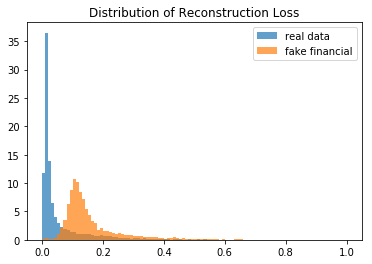

In [266]:
x_fake=make_fake_data(x_test,y_test,ds,num_fakes=7000)
x_fake_fit=ae_321632.model.predict(x_fake)
fake_losses=evaluate_loss(x_fake_fit,x_fake)
fig1=two_class_hist(losses,fake_losses)

No handles with labels found to put in legend.


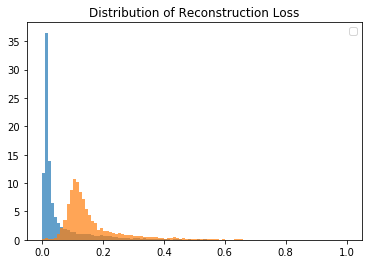

In [264]:
x_fake_h=make_fake_data(x_test,y_test,ds,num_fakes=7000,method='hard')
x_fake_h_fit=ae_321632.model.predict(x_fake)
fake_losses_h=evaluate_loss(x_fake_h_fit,x_fake_h)
fig2=two_class_hist(losses,fake_losses_h)


In [233]:
from sklearn import svm
def fit_svm(losses,fake_losses):
    X=np.append(losses,fake_losses)
    Y=np.append(np.zeros(losses.shape),np.ones(fake_losses.shape))
    X=X.reshape(-1, 1)

    clf=svm.LinearSVC(random_state=35)
    clf.fit(X,Y)
    type1_errors=sum(clf.predict(losses.reshape(-1,1)))
    print(type1_errors)
    type2_errors=fake_losses.shape[0]-sum(clf.predict(fake_losses.reshape(-1,1)))
    print(type2_errors)
    total_error_rate=(type1_errors+type2_errors)/X.shape[0]
    type1_error_rate=type1_errors/losses.shape[0]
    type2_error_rate=type2_errors/fake_losses.shape[0]
    print(fake_losses.shape[0])
    return total_error_rate,type1_error_rate,type2_error_rate
                                       
                      